## Basic utilities

In [ ]:
pip install 'qiskit[visualization]' --quiet

     |████████████████████████████████| 6.0MB 974kB/s 
     |████████████████████████████████| 18.0MB 211kB/s 
     |████████████████████████████████| 235kB 44.9MB/s 
     |████████████████████████████████| 215kB 41.3MB/s 
     |████████████████████████████████| 2.1MB 30.0MB/s 
     |████████████████████████████████| 163kB 48.9MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 1.0MB 32.2MB/s 
     |████████████████████████████████| 194kB 42.8MB/s 
     |████████████████████████████████| 112kB 46.8MB/s 
     |████████████████████████████████| 614kB 35.9MB/s 
     |████████████████████████████████| 3.2MB 32.3MB/s 
     |████████████████████████████████| 6.3MB 35.8MB/s 


In [ ]:
import random, numpy as np, matplotlib.pyplot as plt, pickle
from scipy.optimize import curve_fit
from google.colab import files
from qiskit import execute
from qiskit import pulse            
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit.ignis.characterization.calibrations import rabi_schedules,RabiFitter
from qiskit.tools.monitor import job_monitor

from qiskit import IBMQ
API_KEY = 'd1e0708e9ea899bf5a17e43c1b948223b9c9b66e19dfb58a40fc20b0ee383b8595ef447b340a57fa6e3b9da49c9711efbec30a8a68c77ab235e42662cbba1a62'
IBMQ.save_account(API_KEY, overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
mock_backend = False
if mock_backend:
    from qiskit.providers.aer import PulseSimulator
    from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk
    from qiskit.providers.aer.pulse import PulseSystemModel
    armonk_backend = FakeArmonk()
    armonk_model = PulseSystemModel.from_backend(armonk_backend)
    backend = PulseSimulator()
    # Must change functions too. See https://qiskit.org/documentation/tutorials/circuits_advanced/10_pulse_simulator_backend_model.html
else:
    backend = provider.get_backend('ibmq_armonk')

q = 0 # The index of the qubit to be considered (single qubit backend).

# Get the timestep for the specific backend (duration of the identity gate).
# This is necessary for the decoherence curve fittings, to get the times in 
#the correct units. 
properties = backend.properties()
time_unit = properties.gate_length("id", [q])
freq_est = properties.frequency(q) 
# ^Same as backend.defaults().qubit_freq_est[0] which is the default for driving
#channel.
t1_est = properties.t1(q)
t2_est = properties.t2(q)

properties = backend.properties()
print("The estimated backend properties for the qubit are:")
print("* Resonance frequency: %.2f gigahertz" % (freq_est*1e-9))
print("* T1 time: %.1f microseconds" % (t1_est*1e6))
print("* T2 time: %.1f microseconds" % (t2_est*1e6))

The estimated backend properties for the qubit are:
* Resonance frequency: 4.97 gigahertz
* T1 time: 162.3 microseconds
* T2 time: 263.6 microseconds


In [ ]:
def get_pi_pulse(q,backend_defaults,method=1):
    inst_sched_map = backend_defaults.instruction_schedule_map
    pi_pulse = inst_sched_map.get('x',qubits=[q])
    return pi_pulse

def get_half_pi_pulse(q,backend_defaults,method=1):
    inst_sched_map = backend_defaults.instruction_schedule_map
    half_pi_pulse = inst_sched_map.get('u2',[q],0,np.pi)
    return half_pi_pulse

def get_measure_pulse(q, backend_defaults):
    inst_sched_map = backend_defaults.instruction_schedule_map
    measure = inst_sched_map.get('measure',qubits=[q])
    return measure

## Echoed Ramsey experiment

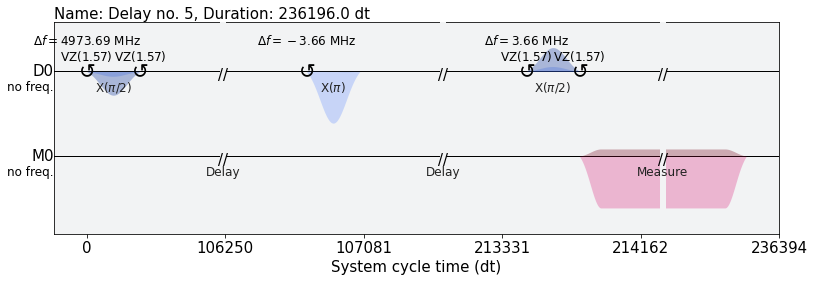

In [ ]:
def get_ramsey_delays(ts,backend_config):
    dt = backend_config.dt
    delays = ts/dt # In the required backend units. 
    return delays

def get_echoed_ramsey_schedules(delta_fs,taus,q,backend_config,backend_defaults):
    delays = get_ramsey_delays(taus,backend_config)
    measure = get_measure_pulse(q,backend_defaults) 
    
    ramsey_schedules = []
    drive_channel = pulse.DriveChannel(q)
    measure_channel = pulse.MeasureChannel(q)
    for i,delay in enumerate(delays):
        with pulse.build(backend,name=f"Delay no. {i}") as schedule:
          with pulse.align_sequential():
            delta_f = random.choice(delta_fs)
            ramsey_frequency = freq_est + delta_f
            neg_ramsey_frequency = freq_est - delta_f
            pulse.set_frequency(ramsey_frequency, drive_channel)
            pulse.u2(0,np.pi,q) # Half pi rotation.
            pulse.delay(int(delay),measure_channel)
            pulse.set_frequency(neg_ramsey_frequency, drive_channel)
            pulse.x(q) # Pi rotation.
            pulse.delay(int(delay),measure_channel)
            pulse.set_frequency(ramsey_frequency, drive_channel)
            pulse.u2(0,np.pi,q) 
            pulse.call(measure)  
        ramsey_schedules.append(schedule)
    return ramsey_schedules

test = True
if test:
  taus = np.linspace(0, 2e-6, 50) # The actual times in seconds.
  tau_max = 350e-6 
  taus = np.linspace(0, tau_max, 75)
  ramsey_schedules = get_echoed_ramsey_schedules([1.83e6,2.52e6],taus,q,
                                                 backend.configuration(),
                                                 backend.defaults())
ramsey_schedules[5].draw()

In [ ]:
def run_echoed_ramsey_job(taus, q, freq_est, delta_fs, backend_config, 
                          backend_defaults,nshots=512):
    ramsey_schedules = get_echoed_ramsey_schedules(delta_fs, taus, q, 
                                  backend_config, backend_defaults)
    drive_channel = pulse.DriveChannel(q)

    ramsey_job = backend.run(ramsey_schedules,meas_level=2,shots=nshots)
    ID = ramsey_job.job_id()
    print(f"Echoed ramsey job ID: '{ID}' [run_echoed_ramsey_job]")
    job_monitor(ramsey_job)
    return ID

run_again = True
if run_again: 
    taus = np.linspace(0.1e-6, 2e-6, 75) # The actual times in seconds.
    delta_fs = [1.83e6,2.78e6]
    job_ID = run_echoed_ramsey_job(taus,q,freq_est,delta_fs,
                                   backend.configuration(),backend.defaults())
else:
    #taus = np.linspace(0, 2.5e-6, 50) # The actual times in seconds.
    #delta_f = 1.83e6
    job_ID = '60aa787207f093867435028b' 

In [ ]:
def get_ramsey_values(backend,job_id):
    # Get the delays in seconds for the plot.
    ramsey_job = backend.retrieve_job(job_id)
    ramsey_results = ramsey_job.result(timeout=120)

    ramsey_values = []
    results = ramsey_results.get_counts()
    for result in results:
        ramsey_values.append(result['0']/sum(result.values()))
    return(ramsey_values)

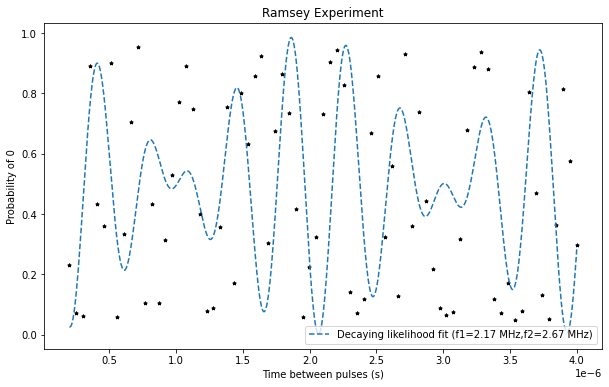

In [ ]:
def decaying_likelihood0(t, f, T2):
    return np.exp(-t/T2)*np.cos(2*np.pi*f*t/2)**2+(1-np.exp(-t/T2))/2

def decaying_likelihood(t, fs):
    likelihoods = [np.cos(2*np.pi*f*t/2)**2 for f in fs]
    return np.mean(likelihoods)

def fit_likelihood(ts, values, smoothen_interpolation=True, print_param=False):
    p0=delta_fs
    parameters,_ = curve_fit(lambda t,f1,f2: decaying_likelihood(t,[f1,f2]), 
                         ts, values, p0=p0, bounds = ([0,0],[10e6,10e6]))
    fs = parameters
    if print_param:
        print("Decaying likelihood curve fit:\n* f1 = %.6f MHz\n* f2 = %.6f MHz" 
              % (f1/1e6,f2/1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = [decaying_likelihood(t, fs) for t in ts]
    
    return parameters,ts,ys

def plot_ramsey_fit(backend,job_id,ts):
    ramsey_values = get_ramsey_values(backend,job_id)
    (f1,f2),extended_ts,ys = fit_likelihood(ts,ramsey_values)
    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, s=12, color='black', marker='*')
    curve_label = ("Decaying likelihood fit (f1=%.2f MHz,f2=%.2f MHz)" % 
                   (f1/1e6,f2/1e6))
    plt.plot(extended_ts,ys,linestyle='dashed',label=curve_label)
    plt.title("Ramsey Experiment")
    plt.xlabel('Time between pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()
delta_fs = [1.83e6,2.78e6]
plot_ramsey_fit(backend,job_ID,2*taus)

## Getting data for the inference

In [ ]:
def get_echoed_data(taus, echoed_ramsey_job):
    echoed_ramsey_result = echoed_ramsey_job.result(timeout=120)
    results = echoed_ramsey_result.get_counts()
    data = []
    for i,dict in enumerate(results):
        new_data = []
        # Shuffle each count because otherwise 0 results always come first
        #(undesirable for the inference).
        for key in dict:
            outcome = int(key)
            # Use times in microseconds.
            datum = (taus[i]*2*1e6,outcome)
            for shot in range(dict[key]):
                new_data.append(datum)
        random.shuffle(new_data)
        data.extend(new_data)
    return data

In [ ]:
tau_min = 0.1e-6 
tau_max = 2e-6 
nsched = 75

rand = False
if rand:
  taus = np.array([random.uniform(tau_min,tau_max) for i in range(nsched)])
else:
  taus = np.linspace(tau_min, tau_max, nsched)

delta_f = 1.83e6
nshots = 1 # Use only one because that's as much granularity for random choice
#as you get

filename_start = 'echoed_ramsey_data[' + str(round(tau_min*1e6*2,1)) + ',' + \
    str(round(tau_max*1e6*2)) + '[' + 'df=' + str(round(delta_f*1e-6,2))  +\
    ('(rand)' if rand else '') + '_sched=' + str(nsched) + '_nshots=' + \
    str(nshots)

runs = 5
try:
    for i in range(runs):
        print("> Run %d." % i)
        # job_ID = run_echoed_ramsey_job(taus,q,freq_est,delta_f,
        #                backend.configuration(),backend.defaults(),nshots=nshots)
        job_ID = '60a584a0671d37e7ecc689ab'
        echoed_ramsey_job = backend.retrieve_job(job_ID)
        data = get_echoed_data(taus,echoed_ramsey_job)
        #data = assemble_echoed_data_vector(2*taus,echoed_ramsey_job)

        filename = filename_start + ('_%d.data' % i)
        print(data)
        with open(filename, 'wb') as filehandle:
            pickle.dump(data, filehandle)
        files.download(filename)
except KeyboardInterrupt:
    print("Quit due to keyboard interrupt.")